# Using YOLOv5 + ByteTrack to compute possession in Europian Football

## Abstract

We us data from https://universe.roboflow.com/ to fine tune the YOLOv5 trained
on the COCO dataset

In [1]:
import os
HOME = os.getcwd()
print(HOME)
# should be just /content

/Users/henrydonahue/Desktop/files/brown-cs/cs1430/computer-vision-visionaries


## Install YOLOv5 trained on COCO dataset <a class="anchor" id="install-yolov5"></a>

In [2]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-162-gc3e4e94 Python-3.9.15 torch-2.0.1 CPU


Setup complete ✅ (8 CPUs, 16.0 GB RAM, 307.0/926.4 GB disk)


### Use custom model trained with football data

https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true

In [3]:
WEIGHTS_PATH = f"{HOME}/best.pt"

In [4]:
model = torch.hub.load(f"{HOME}/yolov5", 'custom', WEIGHTS_PATH, source='local')

YOLOv5 🚀 v7.0-162-gc3e4e94 Python-3.9.15 torch-2.0.1 CPU

Fusing layers... 


requirements: /Users/henrydonahue/Desktop/files/brown-cs/cs1430/computer-vision-visionaries/requirements.txt not found, check failed.


Model summary: 276 layers, 35266236 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


In [5]:
# %cd {HOME}/yolov5
# !python detect.py --weights {HOME}/best.pt --img 1280 --conf 0.25 --source {HOME}/08fd33_0.mp4 --name custom

### Use custom model - single frame

In [6]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

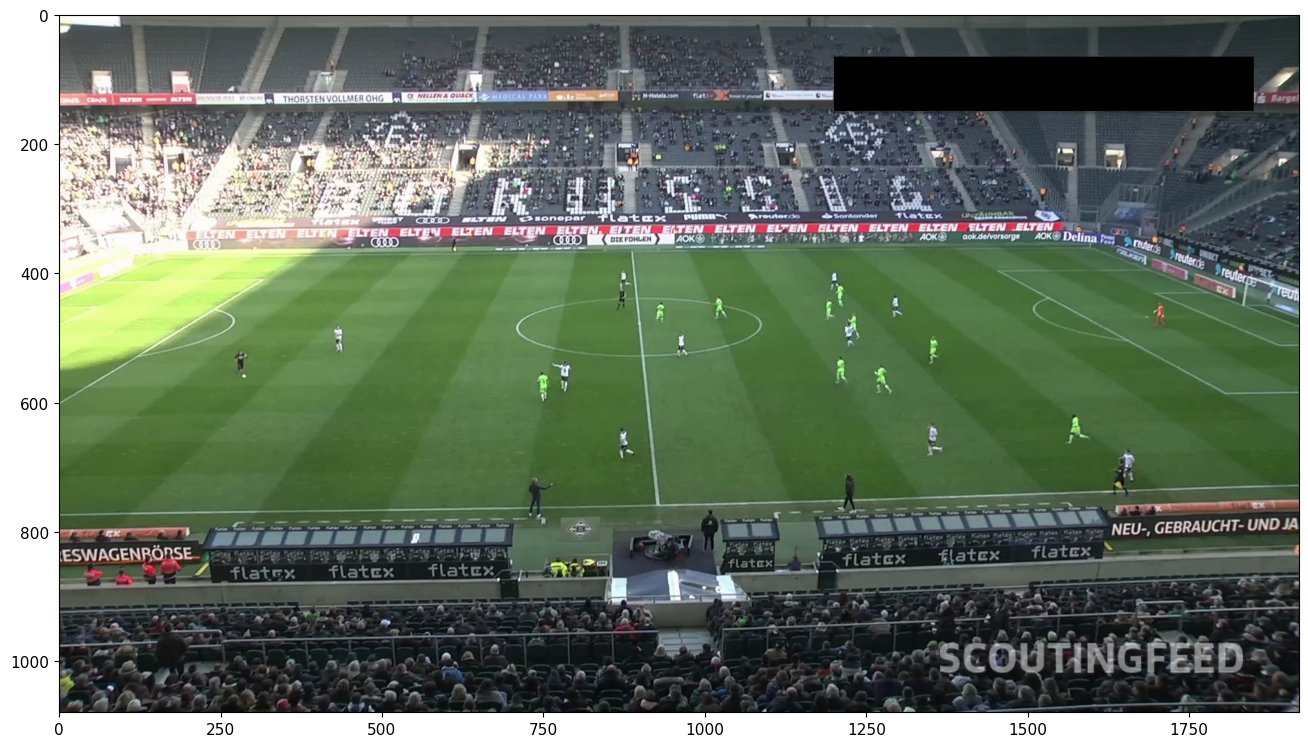

In [7]:
aa = f"{HOME}/08fd33_0.mp4"
frame_iterator_init = iter(generate_frames(video_file=aa))
frame = next(frame_iterator_init)
plot_image(frame, 16)

## Install ByteTrack and other libs<a class="anchor" id="install-bytetrack"></a>

In [8]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack 
%pip install -r requirements.txt
%python3 setup.py develop

%cd {HOME}
%pip install cython
%pip install cython_bbox

/Users/henrydonahue/Desktop/files/brown-cs/cs1430/computer-vision-visionaries
fatal: destination path 'ByteTrack' already exists and is not an empty directory.
/Users/henrydonahue/Desktop/files/brown-cs/cs1430/computer-vision-visionaries/ByteTrack
  Using cached ninja-1.11.1-py2.py3-none-macosx_10_9_universal2.macosx_10_9_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl (270 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached motmetrics-1.4.0-py3-none-any.whl (161 kB)
  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
  Using cached onnx-1.8.1.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      Traceback (most recent call last):
        File "/Users

UsageError: Line magic function `%python3` not found (But cell magic `%%python3` exists, did you mean that instead?).


In [9]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [10]:
%pip install onemetric --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [12]:
%pip install loguru

Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install lap

Note: you may need to restart the kernel to use updated packages.


In [14]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

## Annotator <a class="anchor" id="Annotator"></a>

In [15]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities
@dataclass(frozen=True)
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x
    
    @property
    def min_y(self) -> float:
        return self.y
    
    @property
    def max_x(self) -> float:
        return self.x + self.width
    
    @property
    def max_y(self) -> float:
        return self.y + self.height
        
    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)
    
    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding, 
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )
    
    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities
@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]


# draw utilities
@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image

## Detect ball possession <a class="anchor" id="detect-ball-possession"></a>


In [16]:
# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)


# black
MARKER_CONTOUR_COLOR_HEX = "000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# red
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# blue
PLAYER2_MARKER_FILL_COLOR_HEX = "0000FF"
PLAYER2_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER2_MARKER_FILL_COLOR_HEX)


# green
BALL_MERKER_FILL_COLOR_HEX = "00FF00"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MERKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

# Draw Triangles at location

In [17]:
from typing import List

import numpy as np


# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


# draw single possession marker
def draw_marker(image: np.ndarray, anchor: Point, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(anchor=anchor)
    image = draw_filled_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=color)
    image = draw_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=MARKER_CONTOUR_COLOR,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image


# dedicated annotator to draw possession markers on video frames
@dataclass
class MarkerAnntator:
    color: Color

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_marker(
                image=image, 
                anchor=detection.rect.top_center,
                color=self.color)
        return annotated_image

# Deterrmines who has ball

In [18]:
from typing import List, Optional


# resolves which player is currently in ball possession based on player-ball proximity
def get_player_in_possession(
    player_detections: List[Detection], 
    ball_detections: List[Detection],
    proximity: int
) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    for player_detection in player_detections:
        if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
            return player_detection

# Video config

In [19]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)
    
video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int
        

# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path, 
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
        fps=video_config.fps, 
        frameSize=(video_config.width, video_config.height), 
        isColor=True
    )

# ByteTrack helpers

In [20]:
from typing import List

import numpy as np

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we 
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)

def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:

    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    assign_tracker_id_to_detection(detections, tracks, track2detection, iou)
    return detections


def assign_tracker_id_to_detection(detections, tracks, track2detection, iou):
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id

## Put everything together <a class="anchor" id="put-everything-together"></a>

In [21]:
# settings
SOURCE_VIDEO_PATH = f"{HOME}/08fd33_0.mp4"
TARGET_VIDEO_PATH = f"{HOME}/final/08fd33_4.mp4"

In [22]:
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

player_base_marker_annotator = MarkerAnntator(color=PLAYER2_MARKER_FILL_COLOR)

ref_marker_annotator = MarkerAnntator(color=REFEREE_COLOR)

gk_marker_annotator = MarkerAnntator(color=GOALKEEPER_COLOR)

ball_marker_annotator = MarkerAnntator(color=BALL_MARKER_FILL_COLOR)

player_in_possession_marker_annotator = MarkerAnntator(color=PLAYER_MARKER_FILL_COLOR)


# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator, total=750):

    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    
    # filter detections by class
    ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
    referee_detections = filter_detections_by_class(detections=detections, class_name="referee")
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")
    
    player_goalkeeper_detections = player_detections + goalkeeper_detections
    tracked_detections = player_detections + goalkeeper_detections + referee_detections

    # calculate player in possession
    player_in_possession_detection = get_player_in_possession(
        player_detections=player_goalkeeper_detections,
        ball_detections=ball_detections,
        proximity=PLAYER_IN_POSSESSION_PROXIMITY)

    # track
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

    tracked_referee_detections = filter_detections_by_class(detections=tracked_detections, class_name="referee")
    tracked_goalkeeper_detections = filter_detections_by_class(detections=tracked_detections, class_name="goalkeeper")
    tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")

    # annotate video frame
    annotated_image = frame.copy()
    
    
    annotated_image = ball_marker_annotator.annotate(
        image=annotated_image, 
        detections=ball_detections)
    annotated_image = player_base_marker_annotator.annotate(image=annotated_image, detections = tracked_player_detections)
    annotated_image = ref_marker_annotator.annotate(image=annotated_image, detections = tracked_referee_detections)
    annotated_image = gk_marker_annotator.annotate(image=annotated_image, detections = tracked_goalkeeper_detections)
    annotated_image = player_in_possession_marker_annotator.annotate(
        image=annotated_image, 
        detections=[player_in_possession_detection] if player_in_possession_detection else [])

    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
bbb = f"{HOME}/final/08fd33_4.mp4"
frame_iterator_final = iter(generate_frames(video_file=bbb))
frame = next(frame_iterator_final)
plot_image(frame, 16)